<a href="https://colab.research.google.com/github/CalculatedContent/ww-phys_theory/blob/master/Full_Test_Jacobians_Resnets1001.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Notebook for generating Full Jacobian SVD over the test data for ResNet data

Can do the full calculation, and a batched (slow, but handles large memory cases)

Can handle: ResnetXXX with CIFAR10, CIFAR100, SVHN

i.e. CIFAR 10
```
 resnet20_cifar10
 resnet56_cifar10
 resnet110_cifar10
 resnet164bn_cifar10
 resnet272bn_cifar10

full_jacobian()


 resnet542bn_cifar10
 resnet1001_cifar10
 resnet1202_cifar10

full_batched_jacobian()

```






In [ ]:
Jdir =  '/content/drive/My Drive/J_resnets_fullsvd'

thismodel = 'resnet1001_cifar10'
num_classes= 100
num_data = 10000

batched = True
start_batch = 0
batch_size = 100

device = 'cuda:0'


In [ ]:
!pip install torch==1.5.0+cu101 torchvision==0.6.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [ ]:
!pip install ipython-autotime
%load_ext autotime

  Created wheel for ipython-autotime: filename=ipython_autotime-0.1-cp36-none-any.whl size=1832 sha256=c0bff64ab04d753cb89d74fe35eeda7628902d304526101772c67ff04b8bc8ea
  Stored in directory: /root/.cache/pip/wheels/d2/df/81/2db1e54bc91002cec40334629bc39cfa86dff540b304ebcd6e
Successfully built ipython-autotime


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
time: 26.6 s


In [ ]:
!mkdir "$Jdir"
!ls "$Jdir"

mkdir: cannot create directory ‘/content/drive/My Drive/J_resnets_fullsvd’: File exists
data				   Jfull_resnet1202_cifar10__7.csv
Jfull_resnet1001_cifar10__0.csv    Jfull_resnet1202_cifar10__80.csv
Jfull_resnet1001_cifar10__100.csv  Jfull_resnet1202_cifar10__81.csv
Jfull_resnet1001_cifar10__101.csv  Jfull_resnet1202_cifar10__82.csv
Jfull_resnet1001_cifar10__102.csv  Jfull_resnet1202_cifar10__83.csv
Jfull_resnet1001_cifar10__103.csv  Jfull_resnet1202_cifar10__84.csv
Jfull_resnet1001_cifar10__104.csv  Jfull_resnet1202_cifar10__85.csv
Jfull_resnet1001_cifar10__105.csv  Jfull_resnet1202_cifar10__86.csv
Jfull_resnet1001_cifar10__106.csv  Jfull_resnet1202_cifar10__87.csv
Jfull_resnet1001_cifar10__107.csv  Jfull_resnet1202_cifar10__88.csv
Jfull_resnet1001_cifar10__108.csv  Jfull_resnet1202_cifar10__89.csv
Jfull_resnet1001_cifar10__109.csv  Jfull_resnet1202_cifar10__8.csv
Jfull_resnet1001_cifar10__10.csv   Jfull_resnet1202_cifar10__90.csv
Jfull_resnet1001_cifar10__110.csv  Jfull_resnet1202_ci

In [ ]:
!pip install pytorchcv
!pip install powerlaw
!pip install GPUtil
import GPUtil

     |████████████████████████████████| 440kB 2.8MB/s 
  Created wheel for powerlaw: filename=powerlaw-1.4.6-cp36-none-any.whl size=24787 sha256=3f367440b59ac921b94445209c657b674c379d79ab4e4224301819fae28d02a6
  Stored in directory: /root/.cache/pip/wheels/e0/27/02/08d0e2865072bfd8d7c655e290521e3feca3fc22f1ac460601
Successfully built powerlaw
  Created wheel for GPUtil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7413 sha256=c10fcccf13478f97b3746ed28c4709ff195f7c6cfb77dcdcce41d2f5d5342960
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built GPUtil
time: 10.7 s


In [ ]:
!import os
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image

import math
import copy

import gc


/bin/bash: import: command not found
time: 4.49 s


### Run InstallPhysTheory notebook 

In [ ]:
import sys
sys.path.append("/content/drive/My Drive/Jacobian")
import jacobian as jac
import utils

time: 566 ms


In [ ]:
def jacobian_batched_full(modelname, model, data_loader, batch_size, start_batch = 0, num_classes=10, device='cuda:0', data_dim=3*32*32, formJJ=False, save=True): 
  '''Compute a full of J^{T}J Jacobian in batch mode.  '''

  model.eval() 
  model = model.to(device)

  left_data_loader = data_loader 
  right_data_loader = copy.deepcopy(data_loader)

  JJMat = None 
  for left_batch, data in enumerate(left_data_loader): 
    if left_batch < start_batch:
      continue
    print(left_batch) 

    inputs, _ = data 
    inputs = inputs.to(device)
    inputs.requires_grad=True
    outputs = model(inputs)
    J = jac.batch_diagJ(inputs, outputs)
    J = J.reshape(batch_size,num_classes*data_dim)

    X = J.detach().cpu().numpy()

    del data, inputs, outputs, J
    gc.collect()
    torch.cuda.empty_cache()
    GPUtil.showUtilization()

    JJBlock = None
    for right_batch, data in enumerate(right_data_loader):
      print(left_batch, right_batch)
      inputs, _ = data 
      inputs = inputs.to(device)
      inputs.requires_grad=True
      outputs = model(inputs)
    
      Jt = jac.batch_diagJ(inputs, outputs)
      Jt = Jt.reshape(batch_size,num_classes*data_dim)

      Xt = Jt.detach().cpu().numpy().transpose()

      del data, inputs, outputs, Jt
      gc.collect()
      torch.cuda.empty_cache()

      block = np.dot(X,Xt)
      JJBlock = np.hstack([JJBlock, block]) if JJBlock is not None else block

    # end of right_batch loop
    
    if save:
      filename = "{}/Jfull_{}__{}.csv".format(Jdir, modelname, left_batch)
      np.savetxt(filename, JJBlock, delimiter='\t')
      print("Saved file ",filename)

    if formJJ:
      JJMat = np.vstack([JJMat, JJBlock]) if JJMat is not None else JJBlock

      print("JJMat shape ", left_batch, JJMat.shape, filename) 

  # end of left_batch loop

  return JJMat


time: 59.3 ms


In [ ]:
def jacobian_full(model, data_loader, batch_size, num_classes=10, device='cuda:0'): 
  '''compute a full of J^{T}J Jacobian directly.  '''

  model.eval()
  model = model.to(device)

  J_right = jac.construct_diagJ(model, test_loader, batch_size=batch_size, device=device) 
  J_left = J_right.transpose(1,0)
  JJ = torch.mm(J_right, J_left)
  JJMat = JJ.detach().cpu().numpy()

  del J_right, J_left, JJ
  gc.collect()
  torch.cuda.empty_cache()

  return JJMat

time: 6.16 ms


### ResNet 

In [ ]:
import pytorchcv
from pytorchcv.model_provider import get_model as ptcv_get_model

time: 98.9 ms


### Compute JJ, in batches or all at once


In [ ]:
def get_datasets(thismodel, batch_size):
  print("getting dataset for ", thismodel)
  if thismodel.endswith('cifar100'):
    print("loading cifar100")
    train_dataset = datasets.CIFAR100(
      root='data', 
      train=True, 
      transform=transforms.ToTensor(),
      download=True)
    test_dataset = datasets.CIFAR100(
      root='data', 
      train=False, 
      transform=transforms.ToTensor(),
      download=True) 
 
    train_loader = DataLoader(
      dataset=train_dataset, 
      batch_size=batch_size,
      num_workers=4,
      shuffle=False)
    test_loader = DataLoader(
      dataset=test_dataset, 
      batch_size=batch_size,
      num_workers=4,
      shuffle=False)

  else:
    print("loading cifar10")
    train_dataset, test_dataset, train_loader, test_loader = utils.get_data(batch_size=batch_size)

      
  return train_dataset, test_dataset, train_loader, test_loader

time: 9.94 ms


In [ ]:
print(thismodel)
train_dataset, test_dataset, train_loader, test_loader = get_datasets(thismodel, batch_size)#utils.get_data(batch_size=batch_size)
#train_dataset, test_dataset, train_loader, test_loader = utils.get_data(batch_size=batch_size)

print(test_dataset)
GPUtil.showUtilization()


resnet164bn_cifar100
getting dataset for  resnet164bn_cifar100
loading cifar100


Extracting data/cifar-100-python.tar.gz to data
Files already downloaded and verified
Dataset CIFAR100
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()
| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |
time: 6.17 s


In [ ]:
model = ptcv_get_model(thismodel, pretrained=True)  
if batched: 
  jacobian_batched_full(thismodel, model, test_loader, batch_size=batch_size, num_classes=num_classes, start_batch=start_batch)
else:
  JJMat = jacobian_full(model, test_loader, batch_size=batch_size, num_classes=num_classes)


0
| ID | GPU | MEM |
------------------
|  0 | 61% |  4% |
0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
0 30
0 31
0 32
0 33
0 34
0 35
0 36
0 37
0 38
0 39
0 40
0 41
0 42
0 43
0 44
0 45
0 46
0 47
0 48
0 49
0 50
0 51
0 52
0 53
0 54
0 55
0 56
0 57
0 58
0 59
0 60
0 61
0 62
0 63
0 64
0 65
0 66
0 67
0 68
0 69
0 70
0 71
0 72
0 73
0 74
0 75
0 76
0 77
0 78
0 79
0 80
0 81
0 82
0 83
0 84
0 85
0 86
0 87
0 88
0 89
0 90
0 91
0 92
0 93
0 94
0 95
0 96
0 97
0 98
0 99
Saved file  /content/drive/My Drive/J_resnets_fullsvd/Jfull_resnet164bn_cifar100__0.csv
1
| ID | GPU | MEM |
------------------
|  0 | 54% |  4% |
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
1 14
1 15
1 16
1 17
1 18
1 19
1 20
1 21
1 22
1 23
1 24
1 25
1 26
1 27
1 28
1 29
1 30
1 31
1 32
1 33
1 34
1 35
1 36
1 37
1 38
1 39
1 40
1 41
1 42
1 43
1 44
1 45
1 46
1 47
1 48
1 49
1 50
1 51
1 52
1 53
1 54
1 55
1 56
1 57
1 58
1 59
1 60
1 61
1 6

In [ ]:
if batched:
  print("Reading batched JJBlocks for ", thismodel)
  JJMat = None
  import os, glob
  os.chdir(Jdir)
  for filename in glob.glob("Jfull_{}*".format(thismodel)):
    print(filename)
    JJBlock = np.loadtxt(filename)
    JJMat = np.vstack([JJMat, JJBlock]) if JJMat is not None else JJBlock


Reading batched JJBlocks for  resnet1001_cifar10
Jfull_resnet1001_cifar10__0.csv
Jfull_resnet1001_cifar10__1.csv
Jfull_resnet1001_cifar10__2.csv
Jfull_resnet1001_cifar10__3.csv
Jfull_resnet1001_cifar10__4.csv
Jfull_resnet1001_cifar10__5.csv
Jfull_resnet1001_cifar10__6.csv
Jfull_resnet1001_cifar10__7.csv
Jfull_resnet1001_cifar10__8.csv
Jfull_resnet1001_cifar10__9.csv
Jfull_resnet1001_cifar10__10.csv
Jfull_resnet1001_cifar10__11.csv
Jfull_resnet1001_cifar10__12.csv
Jfull_resnet1001_cifar10__13.csv
Jfull_resnet1001_cifar10__14.csv
Jfull_resnet1001_cifar10__15.csv
Jfull_resnet1001_cifar10__16.csv
Jfull_resnet1001_cifar10__17.csv
Jfull_resnet1001_cifar10__18.csv
Jfull_resnet1001_cifar10__19.csv
Jfull_resnet1001_cifar10__20.csv
Jfull_resnet1001_cifar10__21.csv
Jfull_resnet1001_cifar10__22.csv
Jfull_resnet1001_cifar10__23.csv
Jfull_resnet1001_cifar10__24.csv
Jfull_resnet1001_cifar10__25.csv
Jfull_resnet1001_cifar10__26.csv
Jfull_resnet1001_cifar10__27.csv
Jfull_resnet1001_cifar10__28.csv
Jful

Calculating best minimal value for power law fit
/usr/local/lib/python3.6/dist-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


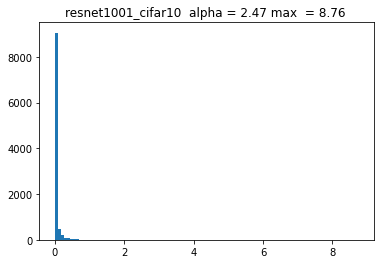

2.471850512418704 0.02320121201362646 8.760446843080521
time: 4min 57s


In [ ]:
import powerlaw
norm = 10*3*32*32 
evals = np.linalg.eigvals(JJMat)
evals  = (1.0/ norm)*evals

fit = powerlaw.Fit(evals)
alpha = fit.alpha
D = fit.D
max_eval = np.max(evals)

plt.hist(evals, bins=100)
plt.title("{}  alpha = {:0.2f} max  = {:0.2f} ".format(thismodel, alpha, max_eval))
plt.show()

print(alpha, D, max_eval)
